<a href="https://colab.research.google.com/github/Alchemist98/Kaggle_Projects/blob/master/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
import numpy as np
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence
import gensim

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [61]:
train = pd.read_csv('/content/train_E6oV3lV.csv')
test = pd.read_csv('/content/test_tweets_anuFYb8.csv')

In [62]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [63]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


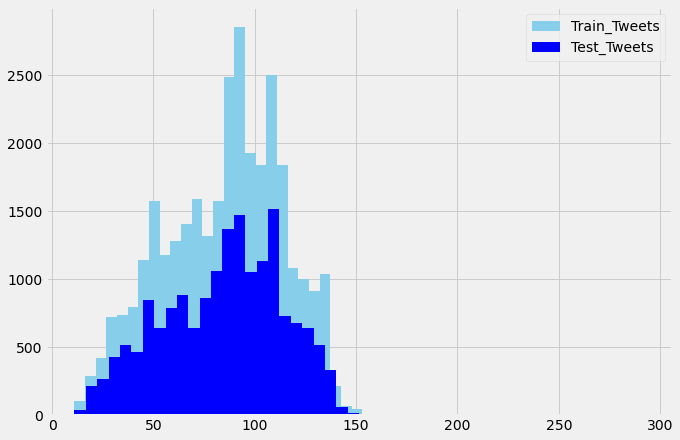

In [64]:
len_train = train['tweet'].str.len()
len_test = test['tweet'].str.len()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,7))
plt.hist(len_train,bins=50,label="Train_Tweets",color='skyblue')
plt.hist(len_test,bins=50,label="Test_Tweets",color='blue')
plt.legend()
plt.show()

In [65]:
labels = train['label'].value_counts()

label_index = labels.index
label_counts = labels.values

colors = ['skyblue','blue']

labels_piechart = go.Pie(labels = label_index,
                         values = label_counts,
                         marker = dict(colors = colors), hole = 0.3)

df = [labels_piechart]

layout = go.Layout(
           title = 'Distribution of labels of Tweets')

fig = go.Figure(data = df,
                 layout = layout)

py.iplot(fig)

In [66]:
merge = train.append(test,ignore_index=True,sort=False)
merge

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is s...
1,2,0.0,@user @user thanks for #lyft credit i can't us...
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation
...,...,...,...
49154,49155,NaN,thought factory: left-right polarisation! #tru...
49155,49156,NaN,feeling like a mermaid ð #hairflip #neverre...
49156,49157,NaN,#hillary #campaigned today in #ohio((omg)) &am...
49157,49158,NaN,"happy, at work conference: right mindset leads..."


In [67]:
for i in range(len(merge['tweet'])):
  merge['tweet'][i] = str(merge['tweet'][i])
  merge['tweet'][i] = merge['tweet'][i].lower()
  merge['tweet'][i] = re.sub('@[\w+]','',merge['tweet'][i])
  merge['tweet'][i] = re.sub('[^a-zA-Z]',' ',merge['tweet'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying t

In [68]:
clean_tweets(merge['tweet'])

In [69]:
merge

,id,label,tweet
0,1,0.0,ser when a father is dysfunctional and is so ...
1,2,0.0,ser ser thanks for lyft credit i can t use ca...
2,3,0.0,bihday your majesty
3,4,0.0,model i love u take with u all the time in ...
4,5,0.0,factsguide society now motivation
...,...,...,...
49154,49155,NaN,thought factory left right polarisation tru...
49155,49156,NaN,feeling like a mermaid hairflip neverre...
49156,49157,NaN,hillary campaigned today in ohio omg am...
49157,49158,NaN,happy at work conference right mindset leads...


In [70]:
def clean_text(sentence):
  sentence = str(sentence)
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(sentence)  
  filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
  stem_words=[stemmer.stem(w) for w in filtered_words]
  lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
  return " ".join(filtered_words)

In [71]:
merge['cleanTweet']=merge['tweet'].map(lambda s:clean_text(s))

In [72]:
merge

,id,label,tweet,cleanTweet
0,1,0.0,ser when a father is dysfunctional and is so ...,ser father dysfunctional selfish drags kids dy...
1,2,0.0,ser ser thanks for lyft credit i can t use ca...,ser ser thanks lyft credit use cause offer whe...
2,3,0.0,bihday your majesty,bihday majesty
3,4,0.0,model i love u take with u all the time in ...,model love take time
4,5,0.0,factsguide society now motivation,factsguide society motivation
...,...,...,...,...
49154,49155,NaN,thought factory left right polarisation tru...,thought factory left right polarisation trump ...
49155,49156,NaN,feeling like a mermaid hairflip neverre...,feeling like mermaid hairflip neverready forma...
49156,49157,NaN,hillary campaigned today in ohio omg am...,hillary campaigned today ohio omg amp used wor...
49157,49158,NaN,happy at work conference right mindset leads...,happy work conference right mindset leads cult...


In [73]:
merge.drop('tweet',axis=1,inplace=True)
merge

,id,label,cleanTweet
0,1,0.0,ser father dysfunctional selfish drags kids dy...
1,2,0.0,ser ser thanks lyft credit use cause offer whe...
2,3,0.0,bihday majesty
3,4,0.0,model love take time
4,5,0.0,factsguide society motivation
...,...,...,...
49154,49155,NaN,thought factory left right polarisation trump ...
49155,49156,NaN,feeling like mermaid hairflip neverready forma...
49156,49157,NaN,hillary campaigned today ohio omg amp used wor...
49157,49158,NaN,happy work conference right mindset leads cult...


In [80]:
from wordcloud import WordCloud

In [81]:
def plot_cloud(words):
  cloud =  WordCloud(width=800,height=500,background_color='grey',random_state=21,max_font_size=110).generate(words)
  plt.figure(figsize=(10,7))
  plt.imshow(cloud,interpolation='bilinear')
  plt.axis("off")

In [82]:
normal_words = ' '.join([text for text in merge['cleanTweet'][merge['label']==0]])
normal_words

'ser father dysfunctional selfish drags kids dysfunction run ser ser thanks lyft credit use cause offer wheelchair vans pdx disapointed getthanked bihday majesty model love take time factsguide society motivation huge fan fare big talking leave chaos pay disputes get allshowandnogo ser camping tomorrow ser ser ser ser ser ser ser danny next school year year exams think school exams hate imagine actorslife revolutionschool girl love land allin cavs champions cleveland clevelandcavaliers ser ser welcome ireland consumer price index mom climbed previous may blog silver gold forex selfish orlando standwithorlando pulseshooting orlandoshooting biggerproblems selfish heabreaking values love get see daddy today days gettingfed ouch junior angry got junior yugyoem omg thankful paner thankful positive friday smiles around via user ser cookies make people know essential oils made chemicals euro people blaming conceded goal fat rooney gave away free kick knowing bale hit sad little dude badday co

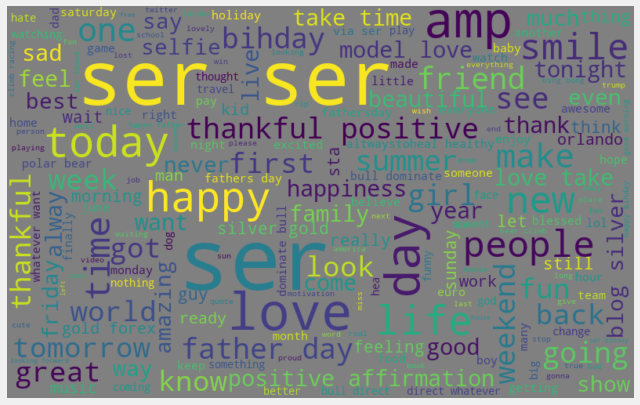

In [83]:
plot_cloud(normal_words)

In [85]:
normal_train_words = ' '.join([text for text in merge['cleanTweet'][merge['label']==1]])
normal_train_words

'ser cnn calls michigan middle school build wall chant tcot comment australia opkillingbay seashepherd helpcovedolphins thecove helpcovedolphins retweet agree ser ser lumpy says prove lumpy unbelievable century need something like neverump xenophobia ser lets fight love peace white establishment blk folx running around loving promoting greatness ser hey white people call people white ser race identity med altright uses amp insecurity lure men whitesupremacy ser interested linguistics address race amp racism power raciolinguistics brings ser ser mocked obama black ser ser ser ser brexit people protesting trump republican trump fuhered amp yes call michelleobama gorilla racists long thought black people bet smaller hands show barry probably lied knicks game sucked golf ser ser point one finger ser millions pointed right back jewishsupremacist might libtard libtard sjw liberal politics ser take trash america voted hate voted voted vot hold open door woman woman nice thing even try deny se

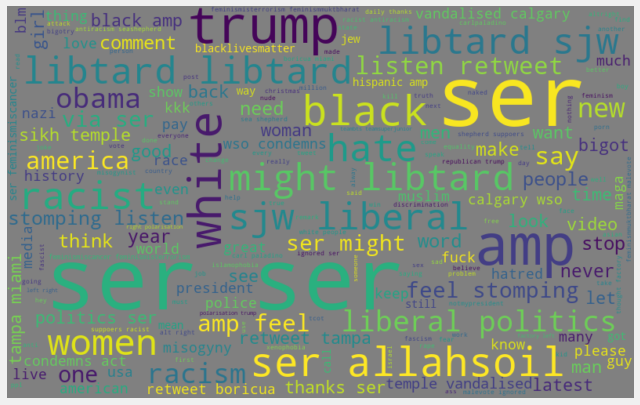

In [86]:
plot_cloud(normal_train_words)

In [89]:
tokenized_tweet = merge['cleanTweet'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(merge['cleanTweet']), epochs=20)

(6554286, 7858940)

In [90]:
model_w2v.wv.most_similar(positive="hate")

[('raison', 0.4870864748954773),
 ('etre', 0.474744975566864),
 ('adl', 0.4575185775756836),
 ('hostility', 0.45362284779548645),
 ('amensia', 0.44936221837997437),
 ('mdcollege', 0.44845977425575256),
 ('pulsevictims', 0.4416928291320801),
 ('witnessing', 0.4398804008960724),
 ('yousuck', 0.43896186351776123),
 ('division', 0.4383237063884735)]

In [105]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [106]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



(49159, 200)

In [107]:
tqdm.pandas(desc="progress-bar")

In [92]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

In [93]:
labeled_tweets = add_label(tokenized_tweet)
labeled_tweets

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).



[LabeledSentence(words=['ser', 'father', 'dysfunctional', 'selfish', 'drags', 'kids', 'dysfunction', 'run'], tags=['tweet_0']),
 LabeledSentence(words=['ser', 'ser', 'thanks', 'lyft', 'credit', 'use', 'cause', 'offer', 'wheelchair', 'vans', 'pdx', 'disapointed', 'getthanked'], tags=['tweet_1']),
 LabeledSentence(words=['bihday', 'majesty'], tags=['tweet_2']),
 LabeledSentence(words=['model', 'love', 'take', 'time'], tags=['tweet_3']),
 LabeledSentence(words=['factsguide', 'society', 'motivation'], tags=['tweet_4']),
 LabeledSentence(words=['huge', 'fan', 'fare', 'big', 'talking', 'leave', 'chaos', 'pay', 'disputes', 'get', 'allshowandnogo'], tags=['tweet_5']),
 LabeledSentence(words=['ser', 'camping', 'tomorrow', 'ser', 'ser', 'ser', 'ser', 'ser', 'ser', 'ser', 'danny'], tags=['tweet_6']),
 LabeledSentence(words=['next', 'school', 'year', 'year', 'exams', 'think', 'school', 'exams', 'hate', 'imagine', 'actorslife', 'revolutionschool', 'girl'], tags=['tweet_7']),
 LabeledSentence(words=

In [94]:

model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model 
                                  dm_mean=1, # dm = 1 for using mean of the context word vectors
                                  size=200, # no. of desired features
                                  window=5, # width of the context window
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 2.
                                  workers=3, # no. of cores
                                  alpha=0.1, # learning rate
                                  seed = 23)

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning:

The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.

100%|██████████| 49159/49159 [00:00<00:00, 2256822.21it/s]


In [95]:
model_d2v.train(labeled_tweets, total_examples= len(merge['cleanTweet']), epochs=15)

In [99]:
docvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(merge)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))
    
docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.shape

(49159, 200)

In [109]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(merge['cleanTweet'])

In [100]:
MODEL_ID = []
Accuracy = []
LOG_CV_ERR = []
F1Score = []
def calculate_log_cv_error(logmodel,X_train,y_train):
    ms_errors= cross_val_score(logmodel, X_train, y_train, cv=5, scoring = make_scorer(mean_squared_error))
    rms_errors = np.sqrt(ms_errors)
    mean_rms_error = rms_errors.mean()
    return mean_rms_error

In [101]:
def evaluate_model(logmodel,X_train,X_test,y_train,y_test,predictions):
    log_cv_error = calculate_log_cv_error(logmodel,X_train,y_train)
    print(f'\nClassification Report:\n{classification_report(y_test,predictions)}')
    print('')
    print(f'\nConfusion Matrix:\n{confusion_matrix(y_test,predictions)}')
    print('')
    print (f'\nAccuracy Score:  {accuracy_score(y_test,predictions)}')
    print("Cross Validation Error: ",log_cv_error)
    logit_roc_auc = roc_auc_score(y_test, logmodel.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, logmodel.predict_proba(X_test)[:,1])
    LOG_CV_ERR.append(log_cv_error)
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split,cross_val_score,KFold

In [112]:
train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'],  
                                                          random_state=42, 
                                                          test_size=0.3)

In [116]:
from sklearn.metrics import f1_score

In [117]:
from sklearn.linear_model import LogisticRegression
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.5327586206896552


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [118]:
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:]

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

In [119]:
lreg.fit(xtrain_w2v, ytrain)

prediction = lreg.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.6338235294117647



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8905
           1       0.64      0.63      0.63       684

    accuracy                           0.95      9589
   macro avg       0.80      0.80      0.80      9589
weighted avg       0.95      0.95      0.95      9589



Confusion Matrix:
[[8660  245]
 [ 253  431]]


Accuracy Score:  0.9480654917092501
Cross Validation Error:  0.21897707568700095


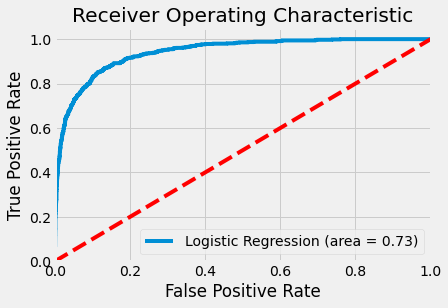

In [122]:
evaluate_model(lreg,xtrain_w2v,xvalid_w2v,ytrain,yvalid,prediction_int)
MODEL_ID.append('Logistic Regression')
Accuracy.append(accuracy_score(yvalid, prediction_int))
F1Score.append(f1_score(yvalid, prediction_int))